<center>![title](../img/sibur.jpg)</center>

<h3>5 место</h3>
<h3>Владимиров Дмитрий</h3>

___

In [1]:
import pickle 
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

### Метрика MAPE

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

___

## Чтение данных

In [3]:
df_train = pd.read_csv('../Data/train_features.csv')
df_test = pd.read_csv('../Data/test_features.csv')

train_targets = pd.read_csv('../Data/train_targets.csv')

ssab = pd.read_csv('../Data/sample_submission.csv')

In [4]:
df = df_train.merge(train_targets, on='timestamp')

### Визуальный анализ

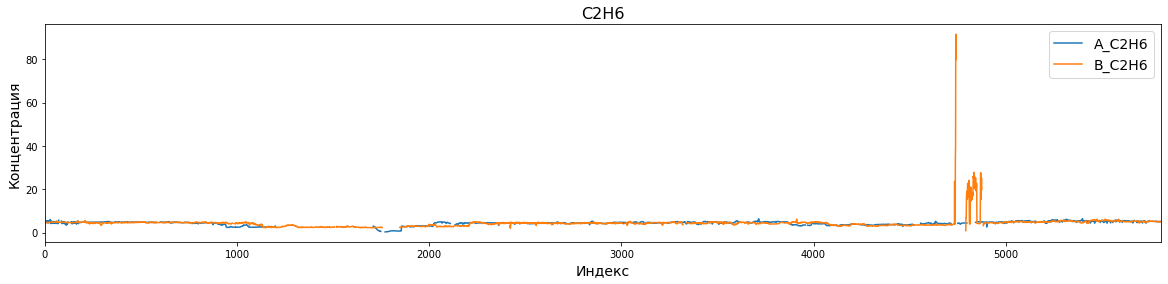

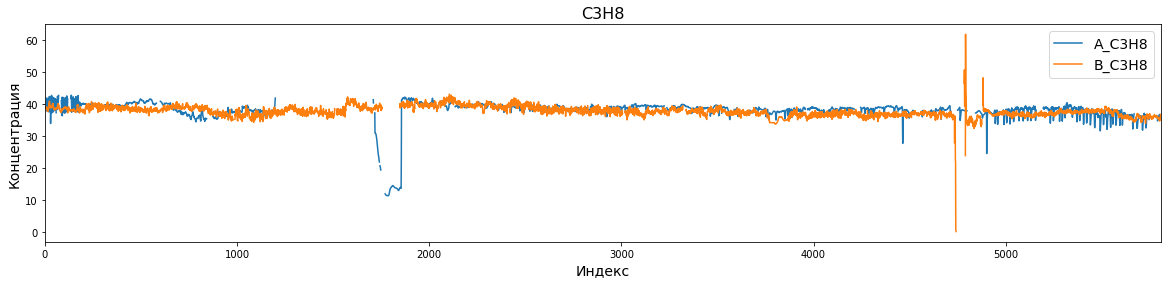

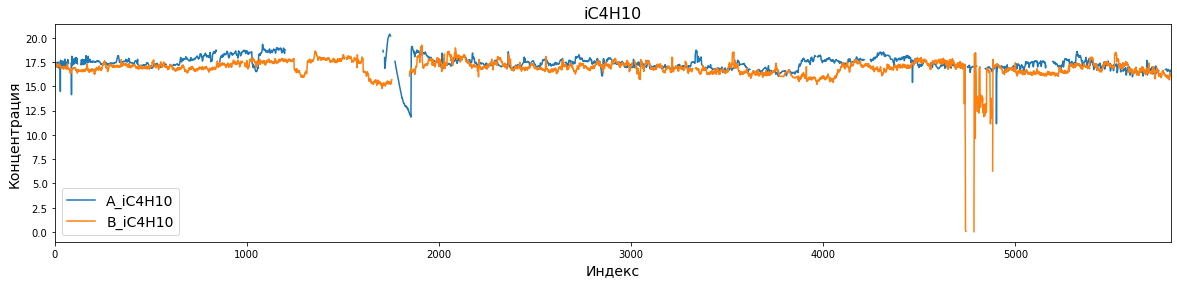

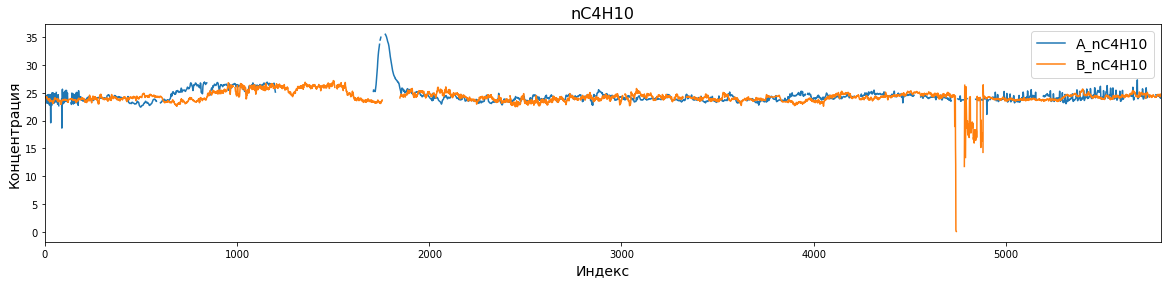

In [5]:
for param in ['C2H6', 'C3H8', 'iC4H10', 'nC4H10']:
    df_plot = df[[f'A_{param}', f'B_{param}']]
    df_plot.plot(figsize=(20, 4))    
    plt.title(param, size=16)
    plt.legend(fontsize=14)
    plt.xlabel('Индекс', size=14);
    plt.ylabel('Концентрация', size=14);    


#### График для тестовой части

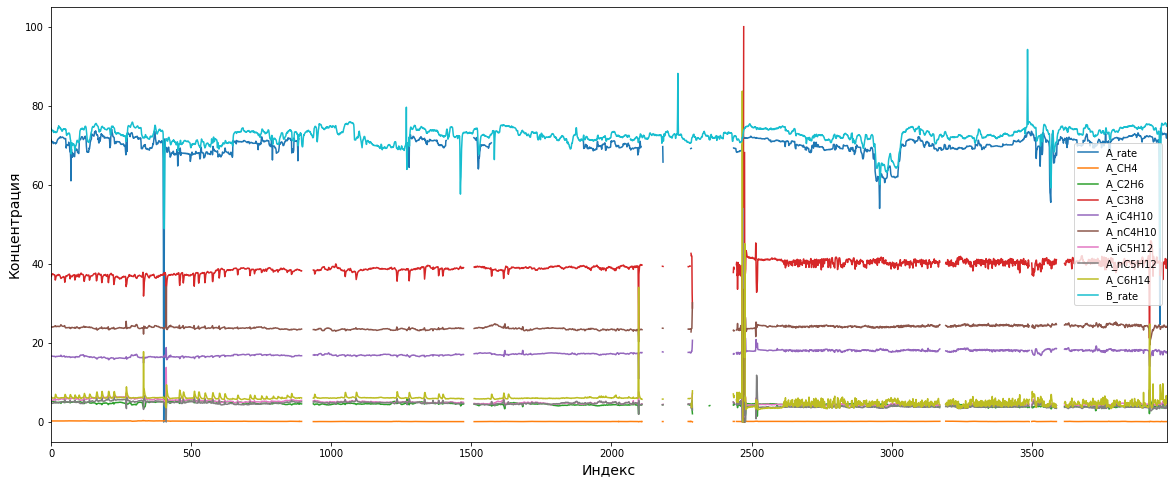

In [6]:
df_test.iloc[:, 1:].plot(figsize=(20, 8))
plt.xlabel('Индекс', size=14);
plt.ylabel('Концентрация', size=14);    

### Фильтрация выбросов

In [7]:
class OutliersCleaner:
    def __init__(self, sigma=1.5):
        self._sigma = sigma
        self._borders = {}
        
    def fit(self, X: pd.DataFrame):
        for col in X.columns:
            if col == 'timestamp':
                continue
            q25 = X[col].quantile(0.25)
            q75 = X[col].quantile(0.75)
            iqr = q75 - q25
            low_border = q25 - iqr * self._sigma
            up_border = q75 + iqr * self._sigma
            self._borders[col] = (low_border, up_border)
        return self
    
    def transform(self, X: pd.DataFrame):
        for col in X.columns:
            if col == 'timestamp':
                continue
            cond = (X[col] <= self._borders[col][0]) | (X[col] >= self._borders[col][1])
            X[col] = np.where(cond, np.nan, X[col])
            X[col] = X[col].fillna(method='pad')
        return X

In [8]:
df_outliers = df.copy()

# Из части трейна выбираем промежутки без сильных выбросов и пропусков в данных (определялось по графикам для трейна)
df_outliers = pd.concat((df_outliers.iloc[:1000], df_outliers[2000:4500], df_outliers[5000:-200]))

In [9]:
cleaner = OutliersCleaner(3).fit(df_outliers)
df = cleaner.transform(df)
df_test = cleaner.transform(df_test)

#### Отфильтрованные ряды

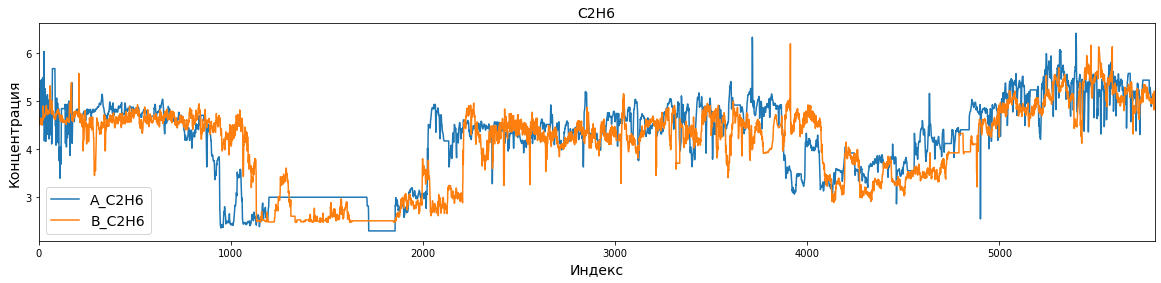

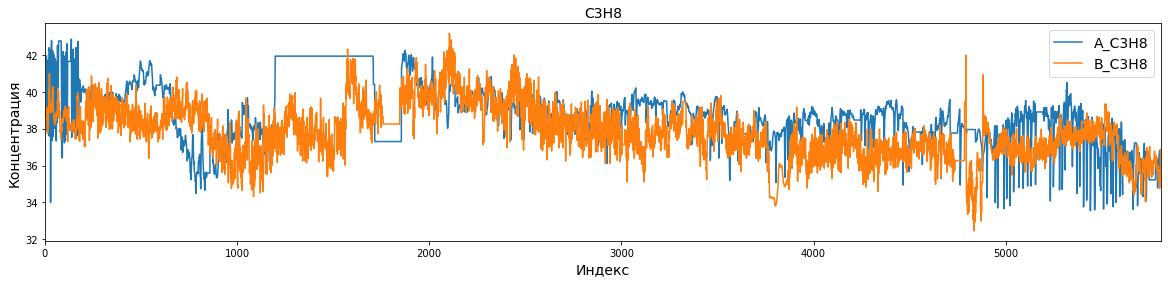

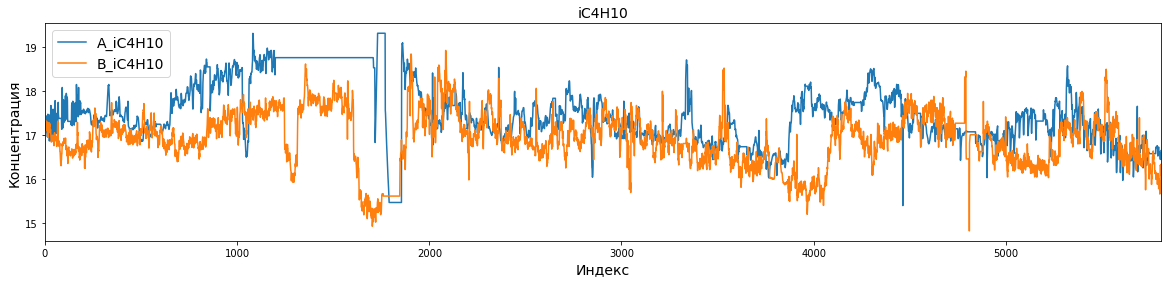

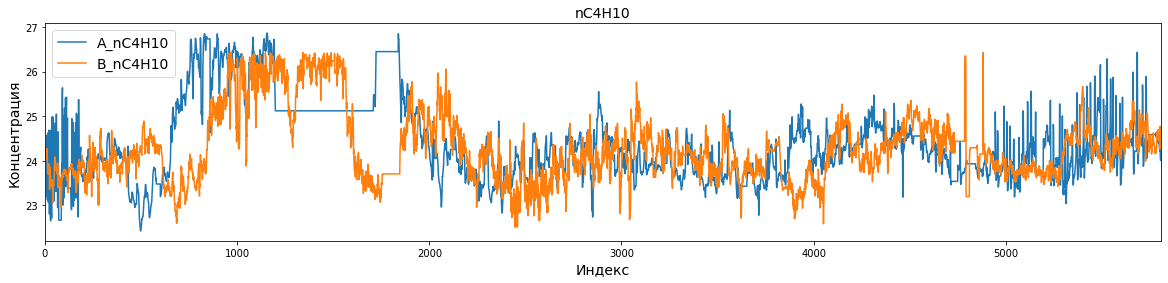

In [10]:
for param in ['C2H6', 'C3H8', 'iC4H10', 'nC4H10']:
    df_plot = df[[f'A_{param}', f'B_{param}']]
    df_plot.plot(figsize=(20, 4))
    plt.title(param, size=14)
    plt.legend(fontsize=14)
    plt.xlabel('Индекс', size=14);
    plt.ylabel('Концентрация', size=14);  


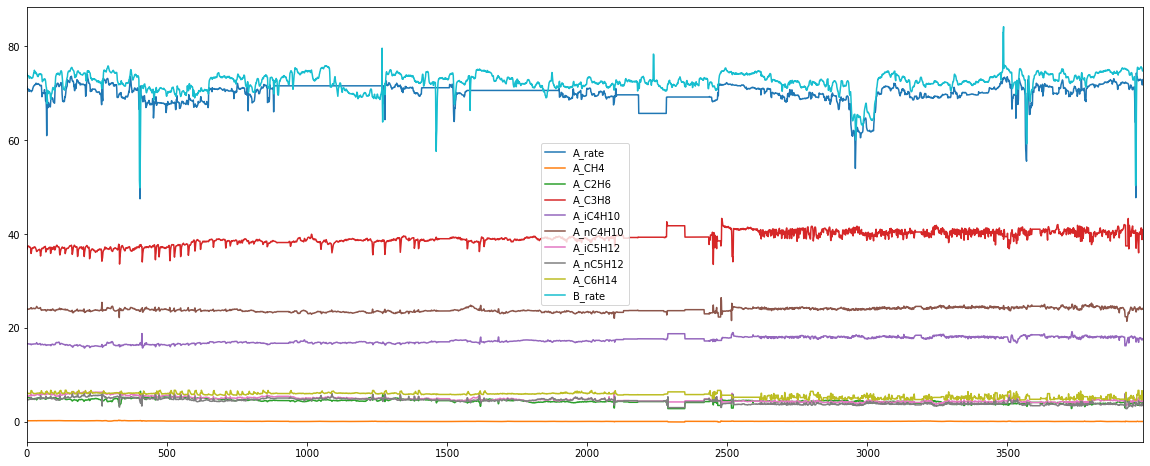

In [11]:
df_test.iloc[:, 1:].plot(figsize=(20, 8))

### Обучение модели прогнозирования сдвига по времени.

#### Для прогнозирования, через какое время смесь, залитая в точке подкачти А, дойдет до точки В, обучалась модель линейной регресии. 

Данные на вход модели получены следующим образом:

1) На временном ряду для каждого из параметров в точке А ['C2H6', 'C3H8', 'iC4H10', 'nC4H10'] последовательно брались промежутки из 200 точек и в цикле делался свиг относильно ряда для аналогичного параметра для точки В, где на каждой итерации считалась корреляция Спирмена между исходным рядом и сдвинутым фрагментом. Сдвиг с наивысшей кореляций считался наилучшим. 

2) Для найденого сдвига считалось средний расход (параметр B_rate) от начала до конца сдвига

In [12]:
def plot_corrs(x, y, param):
    plt.figure(figsize=(12, 6));
    plt.plot(x, y);
    plt.title(param, size=14);
    plt.xlabel('Shift', size=12);
    plt.ylabel('Corr', size=12);    

In [13]:
def getcorr(df, param, lag):
    df_tmp = df[[f'A_{param}', f'B_{param}']].copy()
    df_tmp[f'A_{param}'] = df_tmp[f'A_{param}'].shift(lag)
    corr = df_tmp[[f'A_{param}', f'B_{param}']].corr(method='spearman').iloc[0, 1]
    return corr

In [14]:
def find_lag(df_lag, param, start, w_size, make_plot=True, verbose=True):
    min_lag=1
    max_lag = 230
    step = 1

    best_lag = min_lag
    best_corr = getcorr(df_lag, param, min_lag)
    corrs = [best_corr]

    for i in range(min_lag+1, max_lag+1, step):
        corr = getcorr(df_lag, param, i)
        corrs.append(corr)
        if best_corr < corr:
            best_corr = corr
            best_lag = i
    if make_plot:
        plot_corrs(range(0, max_lag, step), corrs, param)
    if verbose:
        print(f'Best lag {best_lag} with corr {best_corr}')

    press = df_lag.iloc[start: start+w_size+best_lag]['B_rate'].mean()
    return best_lag, press

In [15]:
def findpress(df, w_size=200, step=100, rez=None):
    n = int((df.shape[0] - 300 - w_size) / step + 1)
    if not rez:
        rez = defaultdict(list)
    
    df = df.reset_index(drop=True)
    for param in ['C2H6', 'C3H8', 'iC4H10', 'nC4H10']:
        print(f'Param {param} in processing')

        for i in tqdm_notebook(range(n)):
            tmp = df[['B_rate', f'A_{param}', f'B_{param}']].copy()
            cond = ~pd.Series(tmp.index.values).between(i*step, i*step + w_size)
            tmp.loc[cond, f'A_{param}'] = np.nan
            shift, press = find_lag(tmp, param, i*step, w_size, make_plot=False, verbose=False)
            
            # Оптимальный сдвиг должен лежать в диапазоне от 150 до 220
            if 150 < shift < 220:
                rez['shift'].append(shift)
                rez['press'].append(press)
    return rez  

In [16]:
# Для определения сдвигов брались участки без выбросов

shift_rate = findpress(df.iloc[0:1100])
shift_rate = findpress(df.iloc[2200:4700], rez=shift_rate)
shift_rate = findpress(df.iloc[5000:5750], rez=shift_rate)

Param C2H6 in processing


e:\programs\py\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Param C3H8 in processing



Param iC4H10 in processing



Param nC4H10 in processing



Param C2H6 in processing



Param C3H8 in processing



Param iC4H10 in processing



Param nC4H10 in processing



Param C2H6 in processing



Param C3H8 in processing



Param iC4H10 in processing



Param nC4H10 in processing


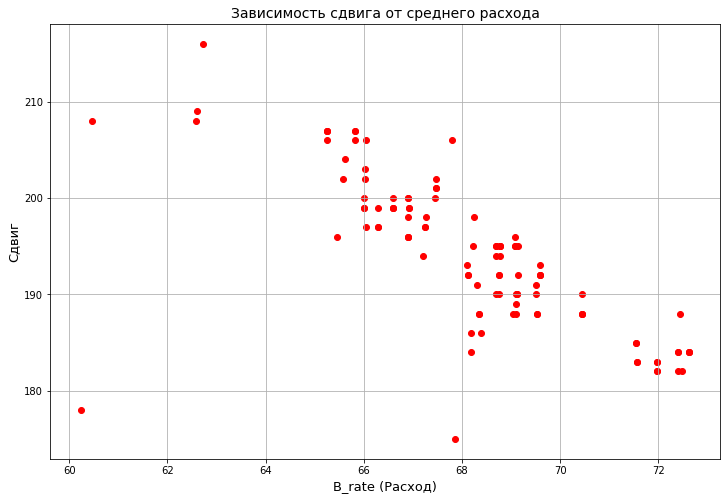

In [17]:
plt.figure(figsize=(12, 8))

plt.scatter(shift_rate['press'], shift_rate['shift'], c='r', label=param);
plt.title('Зависимость сдвига от среднего расхода', size=14)
plt.xlabel('B_rate (Расход)', size=13);
plt.ylabel('Сдвиг', size=13);
plt.grid();

### Обучение модели

In [18]:
df_press = pd.DataFrame(shift_rate)

In [19]:
df_press.head(5)

,shift,press
0,184,72.407570
1,184,72.626387
2,182,71.978292
3,183,71.561598
4,190,70.439878


#### Прогнозируем сдвиг обычной линейной регрессией

In [20]:
linmodel = LinearRegression()
linmodel.fit(df_press['press'].values.reshape(-1, 1), df_press['shift'])

LinearRegression()

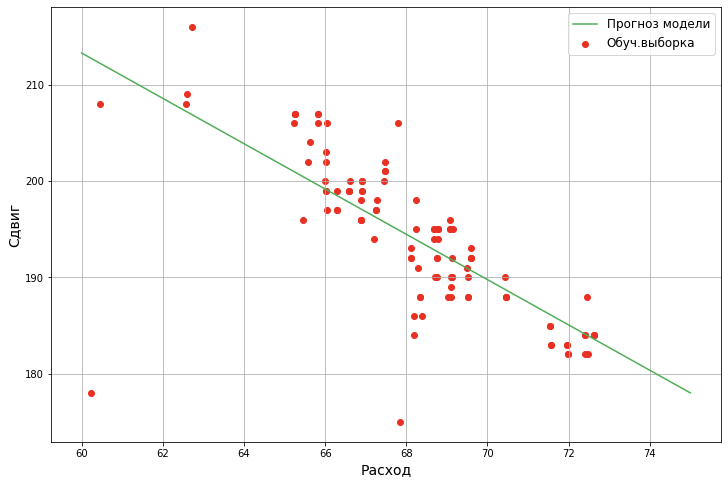

In [21]:
plt.figure(figsize=(12, 8))
plt.scatter(shift_rate['press'], shift_rate['shift'], color='#e83023', label='Обуч.выборка');
plt.xlabel('Расход', size=14);
plt.ylabel('Сдвиг', size=14);

x = np.linspace(60, 75, 100)
y = linmodel.predict(x.reshape(-1, 1))

plt.plot(x, y, color='#50ad58', label='Прогноз модели')
plt.legend(fontsize=12);
plt.grid();

#### Функция для сдвига фичей

In [22]:
def paramshift(df: pd.DataFrame):
    df = df.reset_index(drop=True)
    df_replica = df.copy()
    for param in ['C2H6', 'C3H8', 'iC4H10', 'nC4H10']:
        for ind in range(df.shape[0]):
            sh = ind - df['pred'].iloc[ind]
            if sh-1 >= 0:
                # Усредняем значения (сдвиг-1, сдвиг, сдвиг+1). Можно было не делать, на результат почти не влияет
                val = np.mean((df.loc[sh-1, f'A_{param}'], df.loc[sh, f'A_{param}'], df.loc[sh+1, f'A_{param}']))
            else:
                val = np.nan
            df_replica.loc[ind, f'A_{param}'] = val
    return df_replica

### Обучение моделей прогнозирования концентраций

In [23]:
X = df.copy()

In [24]:
X['press'] = X['B_rate'].rolling(200, min_periods=200).mean()

#### Сдвиг по прогнозам линейной модели

In [25]:
X['pred'] = linmodel.predict(X[['press']].fillna(68).values.reshape(-1, 1))
X['pred'] = X['pred'].apply(int)

In [26]:
X = paramshift(X)

___

#### Обучать модели будем только на участках без выбросов

In [27]:
X = pd.concat((X.iloc[200:1150], X[2200:4700], X[5100:5750]), ignore_index=True)

____

In [28]:
X = X.dropna()

In [29]:
X.head(3)

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,press,pred
0,2020-01-05 04:00:00,71.691732,0.147534,5.112321,39.624579,17.179788,23.848596,3.991090,3.983031,5.625983,72.969045,4.783829,38.051540,16.694837,23.950221,72.706180,183
1,2020-01-05 04:30:00,71.687854,0.146544,5.198534,40.612567,17.121441,23.507175,4.004806,3.998925,5.615800,72.993919,4.747273,38.029839,16.668594,23.940417,72.711324,183
2,2020-01-05 05:00:00,71.666562,0.148398,4.983632,40.176475,17.227334,23.724667,4.001097,3.995454,5.621314,73.028721,4.754264,38.371893,16.721487,23.929174,72.717130,183


### Обучение

In [30]:
cv = TimeSeriesSplit(n_splits=3)
poly = PolynomialFeatures(2)

In [31]:
def fit_ridge(X: pd.DataFrame, y: pd.Series, param: str):
    X = poly.fit_transform(X[f'A_{param}'].values.reshape(-1, 1))
    
    model = Ridge(alpha=0.02, normalize=True, random_state=11)
    score = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(mape))
    model.fit(X, y)
    return model, score

In [32]:
target_names = ['C2H6', 'C3H8', 'iC4H10', 'nC4H10']
models = {}
scores = {}

for param in target_names:
    target = X['B_' + param]
    X_train = X.drop(['timestamp'] + [f'B_{i}' for i in target_names], axis=1)

    models[param], score = fit_ridge(X_train, target, param)
    print(f'Param {param}: score - {np.mean(score)}')
    scores[param] = np.mean(score)
    
print('*'* 30)
print('Avg score ', np.mean(list(scores.values())))
train_cols = X_train.columns

Param C2H6: score - 4.5394848303614275
Param C3H8: score - 2.235325000377665
Param iC4H10: score - 1.4224116141795509
Param nC4H10: score - 1.1404804243148121
******************************
Avg score  2.334425467308364


### Прогноз для тестовой части

#### Объединение sample_submission и признаков

In [33]:
test_part = ssab.merge(df_test.fillna(method='pad'), on='timestamp', how='left')

In [34]:
test_part = pd.concat((df[test_part.columns].iloc[-200:], test_part), sort=False, ignore_index=True)

#### Расчет расхода скользящей средней

In [35]:
test_part['press'] = test_part['B_rate'].rolling(200, min_periods=200).mean()

In [36]:
test_part.head(3)

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,press
0,2020-04-26 20:00:00,5.212032,36.550389,16.682775,24.572895,70.835481,0.209073,4.962986,34.423417,15.983270,24.517070,6.370377,5.569871,6.553273,73.837941,NaN
1,2020-04-26 20:30:00,5.129999,36.362490,16.609390,24.574057,70.630130,0.214240,5.134863,35.424227,15.973183,24.037413,6.121546,5.947547,6.553273,73.779181,NaN
2,2020-04-26 21:00:00,5.093406,36.173314,16.542574,24.533014,70.591853,0.215240,5.309891,36.262602,16.111487,23.837982,5.791332,5.518413,6.553273,73.546568,NaN


#### Сдвиг признаков по прогнозам модели

In [37]:
test_part['pred'] = linmodel.predict(test_part['press'].fillna(68).values.reshape(-1, 1))
test_part['pred'] = test_part['pred'].apply(int)

test_part = paramshift(test_part)

#### Заполнение пропусков медианными значениями из трейна

In [38]:
for param in [col for col in test_part.columns if 'A_' in col]:
    test_part[param] = test_part[param].fillna(df_train[param].median())

In [39]:
test_part = test_part.iloc[200:]

#### Корректировка прогноза

In [40]:
for param in ['C2H6', 'C3H8', 'iC4H10', 'nC4H10']:
    test_part[f'B_{param}'] = models[param].predict(poly.fit_transform(test_part[f'A_{param}'].values.reshape(-1, 1)))

Text(0, 0.5, 'Содержание, %')

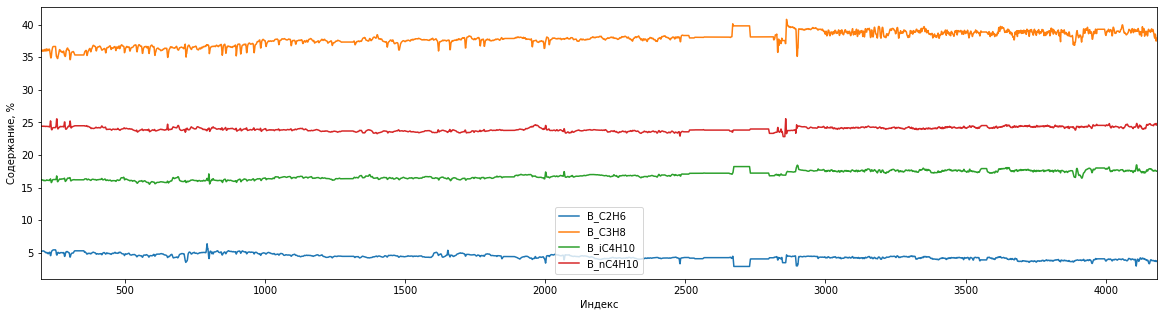

In [41]:
test_part.iloc[:, :5].plot(figsize=(20, 5))
plt.legend();
plt.xlabel('Индекс');
plt.ylabel('Содержание, %')

In [42]:
test_part.iloc[:, :5].to_csv('../Submissions/Submission.csv')